# Import Data and Packages

In [4]:
import os
import sys
import signal
import random
import pickle
import itertools
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import product
from concurrent.futures import ThreadPoolExecutor, as_completed, wait
from joblib import Parallel, delayed
from scipy.stats import boxcox
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_tweedie_deviance
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan, het_arch
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.api as sm
# from kats.consts import TimeSeriesData, SearchMethodEnum
# from kats.models.prophet import ProphetModel, ProphetParams
import kats.utils.time_series_parameter_tuning as tspt
from kats.utils.parameter_tuning_utils import get_default_prophet_parameter_search_space
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
logging.getLogger("fbprophet").setLevel(logging.CRITICAL)

In [5]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [6]:
sell_prices = pd.read_csv('sell_prices.csv').pipe(reduce_mem_usage, verbose=True)
calendar = pd.read_csv('calendar.csv').pipe(reduce_mem_usage, verbose=True)
sales = pd.read_csv('sales_train_evaluation.csv').pipe(reduce_mem_usage, verbose=True)
calendar['date'] = pd.to_datetime(calendar['date'])

Mem. usage decreased to 143.53 Mb (31.2% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.61 Mb (78.9% reduction)


# Data Preprocessing

In [7]:
id_col = ["id"]
ids = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
date_cols = [f"d_{i}" for i in range(1, 1942)]
test_steps = 28
unique_ids = sales["id"].unique()

# Reshape sales data
sales_data = sales[id_col + date_cols].set_index("id").T.reset_index()

# Convert d_XXX to actual dates
date_map = calendar.set_index("d")["date"].to_dict()
sales_data["index"] = sales_data["index"].replace(date_map)

# Rename columns
sales_data.columns = ["date"] + sales_data.columns[1:].tolist()
sales_data.index.name = ""

In [8]:
# events df
index = calendar[["event_name_1", "event_name_2"]].dropna(how="all").index
events = calendar.loc[index, ["date", "event_name_1", "event_name_2"]]
events = (pd.melt(events,id_vars="date",value_vars=["event_name_1", "event_name_2"],value_name="events",).dropna()[["events", "date"]].sort_values("date"))
events.index = range(events.shape[0])
events.columns = ["events", "dates"]
events["lower_window"] = 0
events["upper_window"] = 1
events.head()

,events,dates,lower_window,upper_window
0,SuperBowl,2011-02-06,0,1
1,ValentinesDay,2011-02-14,0,1
2,PresidentsDay,2011-02-21,0,1
3,LentStart,2011-03-09,0,1
4,LentWeek2,2011-03-16,0,1


# Train and Test

In [9]:
train = sales_data[:-test_steps]

In [10]:
test_steps = 28
test = sales_data[-test_steps:]

# Hyperparameter Tuning

In [11]:
# target_id: column names used for hyperparameter search
target_id = [col for col in train.columns if "HOBBIES_1" in col]
target_id = target_id[:20]

In [12]:
def prophet_fit(train_df, params, test_steps, include_history=False):
    ts = TimeSeriesData(df=train_df, sort_by_time=True, time_col_name="date")
    prophet_model = ProphetModel(data=ts, params=params)
    prophet_model.fit()
    prediction = prophet_model.predict(steps=test_steps, include_history=include_history, freq="D")
    return prophet_model, prediction

def evaluation_function(param_dict):
    prophet_params = ProphetParams(
        n_changepoints=param_dict["n_changepoints"],
        changepoint_range=param_dict["changepoint_range"],
        yearly_seasonality="auto",
        weekly_seasonality="auto",
        daily_seasonality="auto",
        seasonality_mode=param_dict["seasonality_mode"],
        seasonality_prior_scale=param_dict["seasonality_prior_scale"],
        changepoint_prior_scale=param_dict["changepoint_prior_scale"],
        holidays_prior_scale=param_dict["holidays_prior_scale"],
        floor=0.0,
    )
    
    tscv = TimeSeriesSplit(n_splits=2)  
    losses = []
    
    for train_index, valid_index in tscv.split(train):
        train_subset = train.iloc[train_index][["date"] + list(target_id)] 
        valid_subset = train.iloc[valid_index][["date"] + list(target_id)]   
        valid_steps = len(valid_subset)  

        y_pred = {}  

        for col in target_id:
            model, forecast = prophet_fit(train_subset[["date", col]].rename(columns={col: "y"}), 
                                          prophet_params, test_steps=valid_steps)
            y_pred[col] = forecast["fcst"].values[:valid_steps] 

        y_pred = np.column_stack(list(y_pred.values()))
        y_true = valid_subset.drop(columns=["date"]).values  

        y_pred = np.maximum(y_pred, 1e-5) 

        if (y_true < 0).any():
            print("⚠️ Warning: `y_true` contains negative values! Clipping to 0.")
            y_true = np.maximum(y_true, 0)

        print(f"✅ Column: {col}, valid_steps: {valid_steps}, y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")  

        loss = mean_tweedie_deviance(y_true.flatten(), y_pred.flatten(), power=1.5)
        losses.append(loss)

    return np.mean(losses)

In [13]:
param_grid = {
    "n_changepoints": [5, 25, 50],  
    "holidays_prior_scale": [0.01, 1.0, 100.0],  
    "changepoint_range": [0.8, 0.9],  
    "seasonality_mode": ["additive", "multiplicative"],  
    "seasonality_prior_scale": [1.0, 10.0],  
    "changepoint_prior_scale": [0.01, 1.0, 10.0],  
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

random.shuffle(param_combinations)
param_combinations = param_combinations[:30]


with ThreadPoolExecutor(max_workers=6) as executor:  
    results = list(executor.map(lambda p: evaluation_function(p), 
                                [dict(zip(param_names, p)) for p in param_combinations]))

best_index = np.argmin(results)
best_params = dict(zip(param_names, param_combinations[best_index]))
best_loss = results[best_index]

print("\nBest Parameters:", best_params)
print("Best Loss:", best_loss)

In [14]:
# Best Parameters: {'n_changepoints': 50, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01}
# Best Loss: 17.08918791110897

In [15]:
import gc
gc.collect()

0

In [16]:
# # **定义 Prophet 训练 & 预测**
# def prophet_fit(train_df, params, include_history=False):
#     ts = TimeSeriesData(df=train_df, sort_by_time=True, time_col_name="date")
#     prophet_model = ProphetModel(data=ts, params=params)  # 这里改成 `params`
#     prophet_model.fit()
#     prediction = prophet_model.predict(steps=test_steps, include_history=include_history, freq="D")
#     return prophet_model, prediction

# # **定义参数搜索空间**
# parameters = get_default_prophet_parameter_search_space()

# parameters.append(
#     {
#         "name": "n_changepoints",
#         "type": "choice",
#         "value_type": "int",
#         "values": [5, 10, 25, 50, 100],
#         "is_ordered": True,
#     }
# )

# parameters.append(
#     {
#         "name": "holidays_prior_scale",   
#         "type": "choice",
#         "value_type": "float",
#         "values": [0.01, 0.1, 1.0, 10.0, 100.0],
#         "is_ordered": True,
#     }
# )

# # **评估 Prophet 参数的效果，使用时间序列交叉验证**
# def evaluation_function(params):
#     """
#     评估 Prophet 参数的效果，使用时间序列交叉验证。
#     """
#     # 设置 Prophet 参数
#     prophet_params = ProphetParams(
#         n_changepoints=params["n_changepoints"],
#         changepoint_range=params["changepoint_range"],
#         yearly_seasonality="auto",
#         weekly_seasonality="auto",
#         daily_seasonality="auto",
#         seasonality_mode=params["seasonality_mode"],
#         seasonality_prior_scale=params["seasonality_prior_scale"],
#         changepoint_prior_scale=params["changepoint_prior_scale"],
#         holidays_prior_scale=params["holidays_prior_scale"],   
#         floor=0.0,
#     )
    
#     # **交叉验证**
#     tscv = TimeSeriesSplit(n_splits=3)
#     losses = []
    
#     for train_index, valid_index in tscv.split(train):

#         train_subset = train.iloc[train_index][["date"] + target_id] 
#         valid_subset = train.iloc[valid_index][["date"] + target_id]   

        
#         # **逐列运行 Prophet**
#         y_pred = {}
#         for col in target_id:  # **只对 target_id 进行 Prophet**
#             model, forecast = prophet_fit(train_subset[["date", col]].rename(columns={col: "y"}), prophet_params)
#             y_pred[col] = forecast["fcst"].values  # 只取预测值

#         # **转换 `y_pred` 为 NumPy 矩阵**
#         y_pred = np.column_stack(list(y_pred.values()))  
#         # **计算误差**
#         y_true = valid_subset.drop(columns=["date"]).values  # 移除时间列
#         loss = mean_tweedie_deviance(y_true.flatten(), y_pred.flatten(), power=1.5)
#         losses.append(loss)

#     final_loss = np.mean(losses)
#     print(f"final_loss: {final_loss:.4f}")
#     return final_loss

# # **贝叶斯优化**
# parameter_tuner = tspt.SearchMethodFactory.create_search_method(
#     parameters=parameters,
#     evaluation_function=evaluation_function,
#     bootstrap_size=10,
#     selected_search_method=SearchMethodEnum.BAYES_OPT,
#     seed=42,
#     multiprocessing=True,
# )

# # **开始运行超参数搜索** 
# parameter_tuner.generate_evaluate_new_parameter_values(
#     evaluation_function=evaluation_function,
#     arm_count=20,   
# )

# # **获取最优参数**
# tuning_results = parameter_tuner.list_parameter_value_scores()
# best_params = tuning_results.loc[tuning_results["mean"].argmin(), "parameters"]

In [19]:
best_params = {
    "n_changepoints": 50,
    "holidays_prior_scale": 1.0,
    "changepoint_range": 0.8,
    "seasonality_mode": "multiplicative",
    "seasonality_prior_scale": 10.0,
    "changepoint_prior_scale": 0.01
}

from kats.models.prophet import ProphetParams

prophet_params = ProphetParams(
    n_changepoints=best_params["n_changepoints"],
    changepoint_range=best_params["changepoint_range"],
    yearly_seasonality=True,  
    weekly_seasonality=True,   
    daily_seasonality="auto",
    holidays=events,
    seasonality_mode=best_params["seasonality_mode"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    holidays_prior_scale=best_params["holidays_prior_scale"],
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    floor=0.0,
)


# Prophet Model

In [25]:
# define train_df
# Filter out hobbies 
target_cols = [col for col in train.columns if "HOBBIES_1" in col]  
target_train = train[["date"] + target_cols]

# group by stores
store_names = [col.split('_')[3] + "_" + col.split('_')[4] for col in target_train.columns[1:]]
store_mapping = dict(zip(target_train.columns[1:], store_names))
target_train = target_train.melt(id_vars=['date'], var_name='item', value_name='sales')
target_train['store'] = target_train['item'].map(store_mapping)
target_train = target_train.groupby(['date', 'store'])['sales'].sum().reset_index()
target_train = target_train.pivot(index='date', columns='store', values='sales').reset_index()
target_columns = target_train.columns[1:] 

# define train_df
# Filter out hobbies 
target_cols = [col for col in test.columns if "HOBBIES_1" in col]  
target_test = test[["date"] + target_cols]

store_names = [col.split('_')[3] + "_" + col.split('_')[4] for col in target_test.columns[1:]]
store_mapping = dict(zip(target_test.columns[1:], store_names))
target_test = target_test.melt(id_vars=['date'], var_name='item', value_name='sales')
target_test['store'] = target_test['item'].map(store_mapping)
target_test = target_test.groupby(['date', 'store'])['sales'].sum().reset_index()
target_test = target_test.pivot(index='date', columns='store', values='sales').reset_index() 

In [26]:
def custom_round(x, threshold=0.4):
    """
    Custom rounding function:
    - If decimal part > threshold, round up to 1
    - Otherwise, round down to 0
    """
    return np.floor(x) + (x % 1 > threshold).astype(int)

def smape(y_true, y_pred):
    """
    smape calculation 
    """
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

def train_and_predict_parallel(train, test, target_col):  #  
    temp = train[["date", target_col]]
    temp_test = test[["date", target_col]]

    # Train Prophet model
    temp_model, temp_train_prediction = prophet_fit(temp, best_params_for_train, test_steps=0, include_history=True)
    temp_model, temp_test_prediction = prophet_fit(temp, best_params_for_train, test_steps=28, include_history=False)

    return {
        "target_col": target_col,   
        "model": temp_model,
        "y_train_actual": temp[target_col].values,
        "y_test_actual": temp_test[target_col].values,
        "y_train_pred": temp_train_prediction["fcst"].values[:len(train)],
        "y_test_pred": temp_test_prediction["fcst"].values
    }

def wrmsse(train, test, forecast):
    """
    Compute Weighted Root Mean Squared Scaled Error (WRMSSE).
    - `train`: historical actual sales data
    - `test`: actual test data
    - `forecast`: predicted test data
    """
    squared_errors = (test - forecast) ** 2
    scale_factor = np.mean(np.diff(train, axis=0) ** 2, axis=0) + 1e-6   
    wrmsse_value = np.sqrt(np.mean(squared_errors / scale_factor, axis=0))
    return np.mean(wrmsse_value)


def signal_handler(sig, frame):
    print("\n Execution Interrupted! Attempting to shut down threads...\n")
    executor.shutdown(wait=False, cancel_futures=True)  # Force shutdown
    sys.exit(1)

In [27]:
events = events.rename(columns={"dates": "ds", "events": "holiday"})
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel

best_params_for_train = ProphetParams( 
    n_changepoints=best_params["n_changepoints"],
    changepoint_range=best_params["changepoint_range"],
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    holidays=events,
    seasonality_mode=best_params["seasonality_mode"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    holidays_prior_scale=best_params["holidays_prior_scale"],
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    floor=0.0,
)

y_train_actual = pd.DataFrame(index=train["date"])   
y_test_actual = pd.DataFrame(index=test["date"])   
y_train_pred = pd.DataFrame(index=train["date"])   
y_test_pred = pd.DataFrame(index=test["date"])

signal.signal(signal.SIGINT, signal_handler)
prophet_models = {}
train_actual_list, test_actual_list = [], []
train_pred_list = []
test_pred_list = []   
columns_list = []

try:
    with ThreadPoolExecutor(max_workers=20) as executor: 
        future_to_target = {executor.submit(train_and_predict_parallel, target_train, target_test, target_col): target_col for target_col in target_columns}

        wait(future_to_target.keys())  

        for future in future_to_target:
            result = future.result()
            target_col = result["target_col"]   
            prophet_models[target_col] = result["model"]
            columns_list.append(target_col)
            train_actual_list.append(pd.Series(result["y_train_actual"], name=target_col))
            test_actual_list.append(pd.Series(result["y_test_actual"], name=target_col))
            train_pred_list.append(pd.Series(custom_round(result["y_train_pred"]), name=target_col))
            test_pred_list.append(pd.Series(custom_round(result["y_test_pred"]), name=target_col))

except KeyboardInterrupt:
    print("\n Interrupt detected! Shutting down threads...\n")
    for future in future_to_target.keys():
        future.cancel()  
    executor.shutdown(wait=False, cancel_futures=True) 
    sys.exit(1)  

In [28]:
y_train_actual = pd.concat(train_actual_list, axis=1).copy()
y_test_actual = pd.concat(test_actual_list, axis=1).copy()
y_train_pred = pd.concat(train_pred_list, axis=1).copy()
y_test_pred = pd.concat(test_pred_list, axis=1).copy()

y_train_actual["Total_Sales_Train"] = y_train_actual.sum(axis=1)
y_test_actual["Total_Sales_Test"] = y_test_actual.sum(axis=1)
y_train_pred["Total_Sales_Train_Pred"] = y_train_pred.sum(axis=1)
y_test_pred["Total_Sales_Test_Pred"] = y_test_pred.sum(axis=1)
y_test_pred.head()

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,Total_Sales_Test_Pred
0,489.0,309.0,543.0,396.0,244.0,309.0,350.0,327.0,208.0,216.0,3391.0
1,460.0,299.0,523.0,391.0,230.0,286.0,326.0,327.0,204.0,203.0,3249.0
2,451.0,298.0,525.0,371.0,225.0,295.0,321.0,344.0,211.0,212.0,3253.0
3,457.0,305.0,517.0,381.0,235.0,296.0,329.0,350.0,210.0,207.0,3287.0
4,530.0,365.0,568.0,395.0,271.0,345.0,372.0,443.0,240.0,271.0,3800.0


# Model Evaluation

---Total Sales Training Metrics---:
RMSE: 339.8858, MAE: 267.5761, SMAPE: 0.0991
---Total Sales Testing Metrics---:
RMSE: 248.1355, MAE: 178.6071, SMAPE: 0.0484


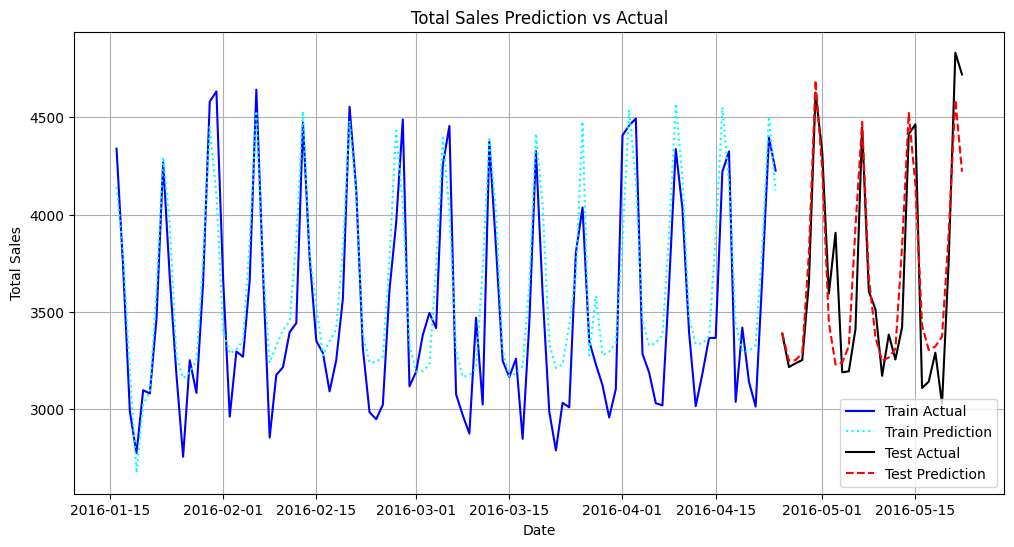

In [29]:
# Evaluation metrics
rmse_train = mean_squared_error(y_train_actual["Total_Sales_Train"], y_train_pred["Total_Sales_Train_Pred"], squared=False)
mae_train = mean_absolute_error(y_train_actual["Total_Sales_Train"], y_train_pred["Total_Sales_Train_Pred"])
smape_train = smape(y_train_actual["Total_Sales_Train"], y_train_pred["Total_Sales_Train_Pred"])

rmse_test = mean_squared_error(y_test_actual["Total_Sales_Test"], y_test_pred["Total_Sales_Test_Pred"], squared=False)
mae_test = mean_absolute_error(y_test_actual["Total_Sales_Test"], y_test_pred["Total_Sales_Test_Pred"])
smape_test = smape(y_test_actual["Total_Sales_Test"], y_test_pred["Total_Sales_Test_Pred"])

print("---Total Sales Training Metrics---:")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, SMAPE: {smape_train/100:.4f}")

print("---Total Sales Testing Metrics---:")
print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, SMAPE: {smape_test/100:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train["date"][-100:], y_train_actual["Total_Sales_Train"][-100:], label="Train Actual", color="blue")
plt.plot(train["date"][-100:], y_train_pred["Total_Sales_Train_Pred"][-100:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test["date"], y_test_actual["Total_Sales_Test"], label="Test Actual", color="black")
plt.plot(test["date"], y_test_pred["Total_Sales_Test_Pred"], label="Test Prediction", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
wrmsse_value = wrmsse(y_train_actual[target_columns].values, 
                       y_test_actual[target_columns].values, 
                       y_test_pred[target_columns].values)
wrmsse_value

0.9587583337220973

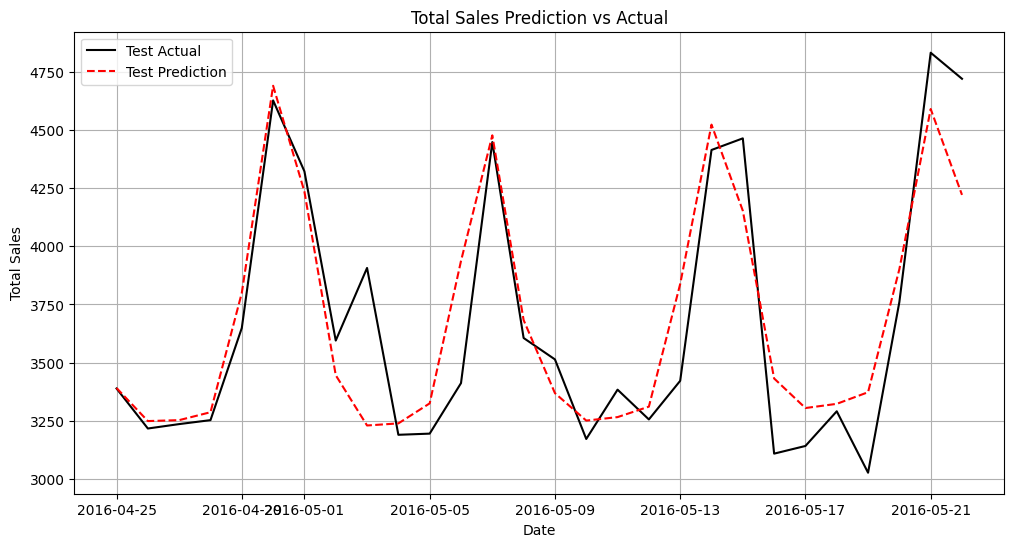

In [31]:
plt.figure(figsize=(12, 6))
# plt.plot(train["date"][-100:], y_train_actual["Total_Sales_Train"][-100:], label="Train Actual", color="blue")
# plt.plot(train["date"][-100:], y_train_pred["Total_Sales_Train_Pred"][-100:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test["date"], y_test_actual["Total_Sales_Test"], label="Test Actual", color="black")
plt.plot(test["date"], y_test_pred["Total_Sales_Test_Pred"], label="Test Prediction", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

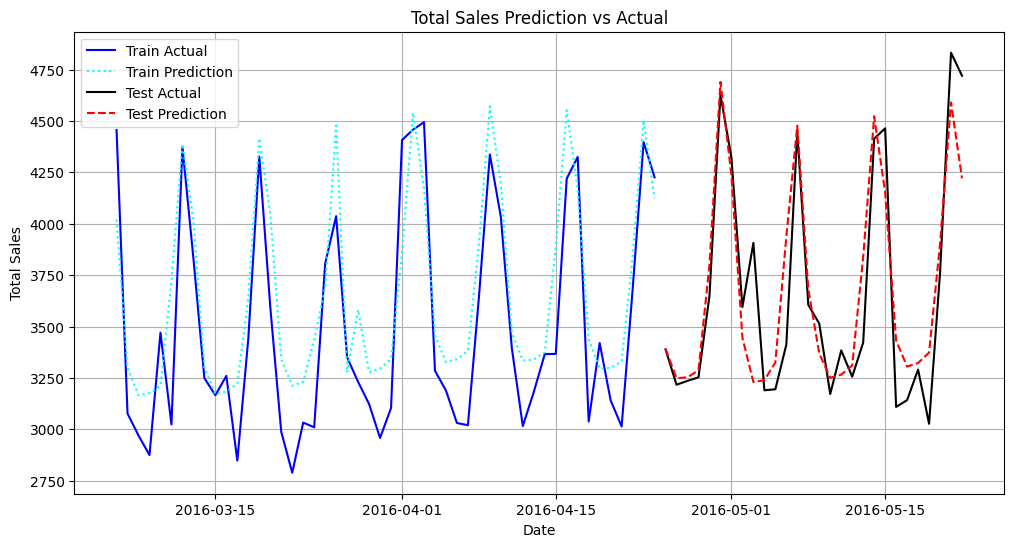

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(train["date"][-50:], y_train_actual["Total_Sales_Train"][-50:], label="Train Actual", color="blue")
plt.plot(train["date"][-50:], y_train_pred["Total_Sales_Train_Pred"][-50:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test["date"], y_test_actual["Total_Sales_Test"], label="Test Actual", color="black")
plt.plot(test["date"], y_test_pred["Total_Sales_Test_Pred"], label="Test Prediction", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

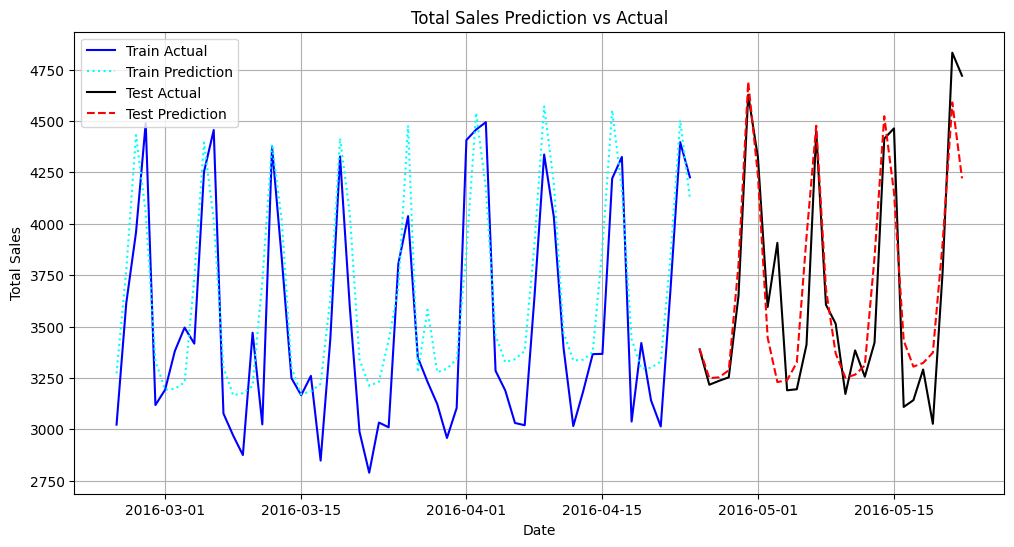

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(train["date"][-60:], y_train_actual["Total_Sales_Train"][-60:], label="Train Actual", color="blue")
plt.plot(train["date"][-60:], y_train_pred["Total_Sales_Train_Pred"][-60:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test["date"], y_test_actual["Total_Sales_Test"], label="Test Actual", color="black")
plt.plot(test["date"], y_test_pred["Total_Sales_Test_Pred"], label="Test Prediction", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

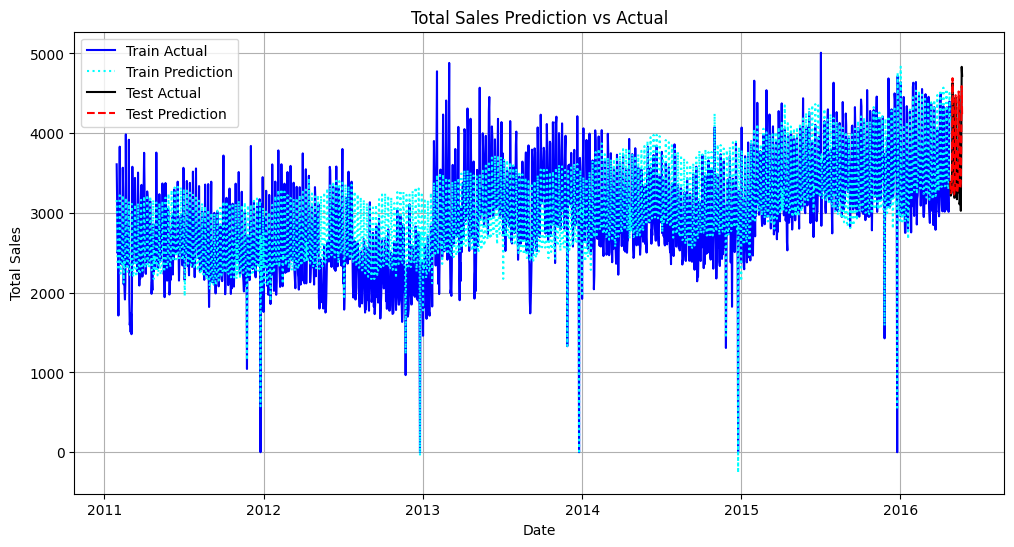

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(train["date"], y_train_actual["Total_Sales_Train"], label="Train Actual", color="blue")
plt.plot(train["date"], y_train_pred["Total_Sales_Train_Pred"], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test["date"], y_test_actual["Total_Sales_Test"], label="Test Actual", color="black")
plt.plot(test["date"], y_test_pred["Total_Sales_Test_Pred"], label="Test Prediction", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

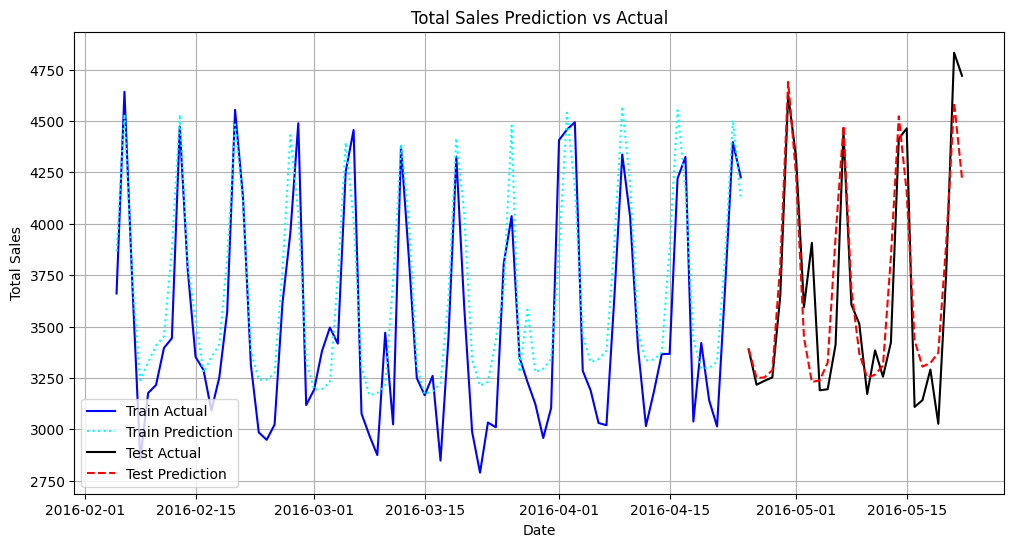

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(train["date"][-80:], y_train_actual["Total_Sales_Train"][-80:], label="Train Actual", color="blue")
plt.plot(train["date"][-80:], y_train_pred["Total_Sales_Train_Pred"][-80:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test["date"], y_test_actual["Total_Sales_Test"], label="Test Actual", color="black")
plt.plot(test["date"], y_test_pred["Total_Sales_Test_Pred"], label="Test Prediction", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

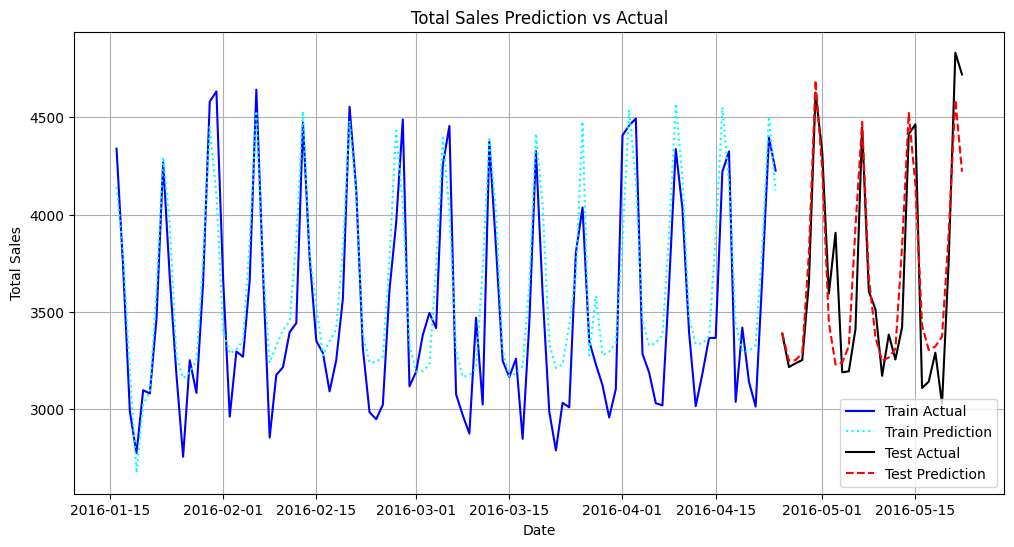

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(train["date"][-100:], y_train_actual["Total_Sales_Train"][-100:], label="Train Actual", color="blue")
plt.plot(train["date"][-100:], y_train_pred["Total_Sales_Train_Pred"][-100:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test["date"], y_test_actual["Total_Sales_Test"], label="Test Actual", color="black")
plt.plot(test["date"], y_test_pred["Total_Sales_Test_Pred"], label="Test Prediction", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Define MAPE function
def mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error
    Handles zeros in actual values by adding a small epsilon
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Add small epsilon to prevent division by zero
    epsilon = 1e-10
    # Calculate MAPE
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Evaluation metrics
rmse_train = mean_squared_error(y_train_actual["Total_Sales_Train"], y_train_pred["Total_Sales_Train_Pred"], squared=False)
mae_train = mean_absolute_error(y_train_actual["Total_Sales_Train"], y_train_pred["Total_Sales_Train_Pred"])
smape_train = smape(y_train_actual["Total_Sales_Train"], y_train_pred["Total_Sales_Train_Pred"])
mape_train = mape(y_train_actual["Total_Sales_Train"], y_train_pred["Total_Sales_Train_Pred"])

rmse_test = mean_squared_error(y_test_actual["Total_Sales_Test"], y_test_pred["Total_Sales_Test_Pred"], squared=False)
mae_test = mean_absolute_error(y_test_actual["Total_Sales_Test"], y_test_pred["Total_Sales_Test_Pred"])
smape_test = smape(y_test_actual["Total_Sales_Test"], y_test_pred["Total_Sales_Test_Pred"])
mape_test = mape(y_test_actual["Total_Sales_Test"], y_test_pred["Total_Sales_Test_Pred"])

print("---Total Sales Training Metrics---:")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, SMAPE: {smape_train/100:.4f}, MAPE: {mape_train:.4f}%")

print("---Total Sales Testing Metrics---:")
print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, SMAPE: {smape_test/100:.4f}, MAPE: {mape_test:.4f}%")

# Plot remains the same
plt.figure(figsize=(12, 6))
plt.plot(train["date"][-100:], y_train_actual["Total_Sales_Train"][-100:], label="Train Actual", color="blue")
plt.plot(train["date"][-100:], y_train_pred["Total_Sales_Train_Pred"][-100:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test["date"], y_test_actual["Total_Sales_Test"], label="Test Actual", color="black")
plt.plo

---Total Sales Training Metrics---:
RMSE: 339.8858, MAE: 267.5761, SMAPE: 0.0991, MAPE: 745948771572.5950%
---Total Sales Testing Metrics---:
RMSE: 248.1355, MAE: 178.6071, SMAPE: 0.0484, MAPE: 4.8601%
